In [53]:
%load_ext autoreload
%autoreload 2
from transformer import SpeechTransformer
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, BinaryDataset, create_sampler
from training_pipeline import repeat_training
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

SEED = 42
set_seed(SEED)

In [37]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

# train_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.TRAIN)
# val_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.VAL)
# test_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.TEST)

batch_size = 512
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

In [38]:
sampler = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers)

In [46]:
def init_transformer_1():
    return SpeechTransformer(nhead=4, num_layers=4)

repetitions = 1
lr = 0.001
epochs = 100
tolerance = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dir = "output/models/transformer"
history_dir = "output/history/transformer"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

model_path = model_dir + "/transformer.pth"
history_path = history_dir + "/transformer.pkl"

repeat_training(repetitions, init_transformer_1, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance)

training iteration: 1 of 1
starting training...
epoch: 1, training loss: 0.0047064742165003086, training accuracy: 11.19636705292828
epoch: 1, validation loss: 0.004901792134001312, validation accuracy: 6.472491909385114
model saved

epoch: 2, training loss: 0.0044007398213781685, training accuracy: 18.170607579079235
epoch: 2, validation loss: 0.0050105594753973555, validation accuracy: 8.414239482200648

epoch: 3, training loss: 0.004219029951610798, training accuracy: 22.097165674913875
epoch: 3, validation loss: 0.004520285774869546, validation accuracy: 13.415710503089144
model saved

epoch: 4, training loss: 0.0038824306081687624, training accuracy: 28.413717507046666
epoch: 4, validation loss: 0.004892951374581436, validation accuracy: 10.885554574874963

epoch: 5, training loss: 0.00349615729185544, training accuracy: 37.58808330723458
epoch: 5, validation loss: 0.004683837097299278, validation accuracy: 17.358046484260075

epoch: 6, training loss: 0.0029769540183080465, traini

In [47]:
best_model = init_transformer_1()
best_model.to(device)
best_model.load_state_dict(torch.load("output/models/transformer/transformer_1.pth", weights_only=True))

<All keys matched successfully>

In [50]:
all_preds = []
best_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        # print(predicted)
        all_preds.extend(predicted.cpu().tolist())

pred_counts = Counter(all_preds)
sorted_pred_counts = dict(sorted(pred_counts.items()))
print(sorted_pred_counts)

{0: 389, 1: 573, 2: 665, 3: 893, 4: 386, 5: 526, 6: 615, 7: 228, 8: 383, 9: 641, 10: 1536}


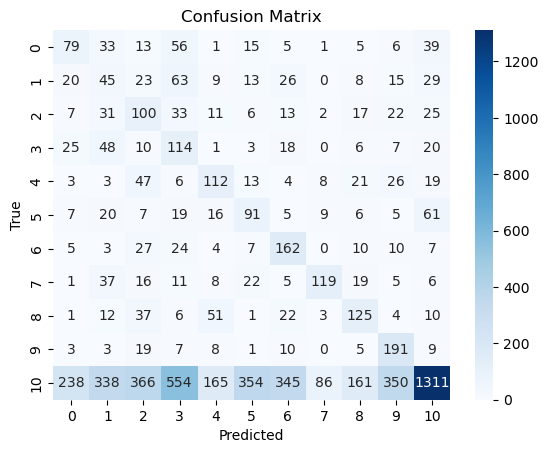

In [70]:
true_labels = []
predictions = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        
        true_labels.extend(y.cpu().tolist())
        predictions.extend(predicted.cpu().tolist())

unique_labels = np.unique(true_labels)
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [26]:
test_dataset.label_map

{'unknown': 1,
 'down': 0,
 'go': 0,
 'left': 0,
 'no': 0,
 'off': 0,
 'on': 0,
 'right': 0,
 'stop': 0,
 'up': 0,
 'yes': 0}